# 基于BERT模型的文本分类

本文主要介绍了基于`BERT`模型提取词向量，并应用于文本分类模型之中

## 语料处理

In [1]:
import numpy as np
import pandas as pd
import glob

# 获取所有语料路径
doc_files = glob.glob('data/*/*.txt')

# 根据文件名处理语料的类别
file_cat = []
for file_name in doc_files:
    category = file_name.split('/')[1].split('-')[1]
    file_cat.append((file_name, category))
    
file_pd = pd.DataFrame(file_cat, columns=['file', 'category'])
file_pd.iloc[:5]

,file,category
0,data/C39-Sports/C39-Sports0025.txt,Sports
1,data/C39-Sports/C39-Sports0743.txt,Sports
2,data/C39-Sports/C39-Sports0757.txt,Sports
3,data/C39-Sports/C39-Sports1449.txt,Sports
4,data/C39-Sports/C39-Sports0031.txt,Sports


## 语料预处理方法

In [2]:
import re

# 保留中文、英语字母、数字和标点
graph_filter = re.compile(r'[^\u4e00-\u9fa5a-zA-Z0-9\s，。\.,？\?!！；;]')
# 按标点分割句子
graph_split_sentence = re.compile(r'\n|。|，|？|！|；|\.|,|\?|\!|;')

# 将文章切分为句子
def process_sentences(graph):
    sentences = graph_split_sentence.split(graph)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    return sentences

## 切分训练集与测试集

In [3]:
from sklearn.model_selection import train_test_split

files_train, files_test, y_train, y_test = train_test_split(file_pd['file'], file_pd['category'], test_size=0.3, 
                                                            stratify=file_pd['category'], random_state=1024)

## 使用BERT模型将文档处理成向量

采用[bert-as-service](https://github.com/hanxiao/bert-as-service)作为`BERT`模型服务接口，`BERT`模型使用[multi_cased_L-12_H-768_A-12](https://github.com/google-research/bert#pre-trained-models)

- Bert Server端启动

- 设置BERT客户端

In [4]:
from bert_serving.client import BertClient
bert_client = BertClient(check_length=False)

- 生成数据文档训练

In [5]:
# 生成训练集文档向量
train_word_vec = []
for i, file in enumerate(files_train):
    try:
        with open(file, 'r', encoding='GB18030') as f:
            graph = f.read()
            graph = graph_filter.sub('', graph)
        sentences = process_sentences(graph)
        result = bert_client.encode(sentences)
        # 将语句进行平均处理成向量
        result = result.mean(axis=0)
        train_word_vec.append(result)
    except Exception as e:
        print('\t{} -> {}'.format(i, e), end='\t')
        train_word_vec.append(np.zeros(768))

train_vec = np.load('train_vec.npy')
train_vec.shape, y_train.shape

((1892, 768), (1892,))

In [6]:
# 生成测试集文档向量
test_word_vec = []
for i, file in enumerate(files_test):
    try:
        with open(file, 'r', encoding='GB18030') as f:
            graph = f.read()
            graph = graph_filter.sub('', graph)
        sentences = process_sentences(graph)
        result = bert_client.encode(sentences)
        result = result.mean(axis=0)
        test_word_vec.append(result)
    except Exception as e:
        print('\t{} -> {}'.format(i, e), end='\t')
        test_word_vec.append(np.zeros(768))

test_vec = np.vstack(test_word_vec)
test_vec.shape, y_test.shape

((812, 768), (812,))

- 使用`t-SNE`算法进行降维来可视化文档

In [7]:
from sklearn.manifold import TSNE

all_vec = np.vstack((train_vec, test_vec))
all_label = np.hstack((y_train.values, y_test.values))

tsne = TSNE(metric='cosine')
tsne_result = tsne.fit_transform(all_vec)
tsne_result.shape, all_label.shape

((2704, 2), (2704,))

- 可视化`t-SNE`算法结果

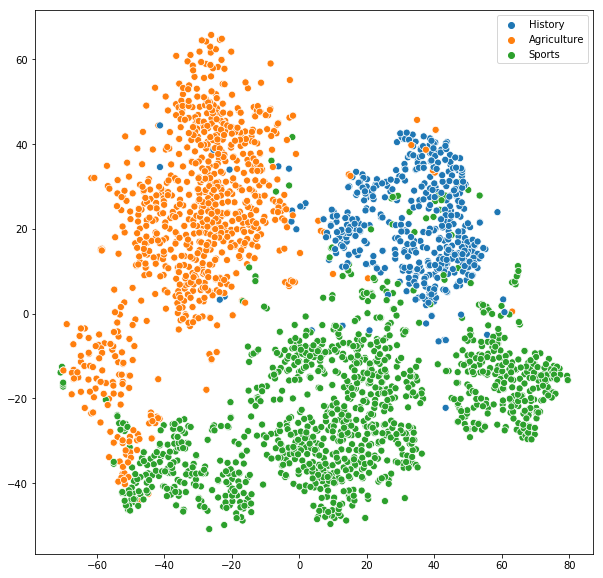

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.scatterplot(tsne_result[:, 0], tsne_result[:, 1], hue=all_label, s=50)
plt.show()

## 模型

### 训练逻辑斯蒂回归模型

In [10]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
lr_params = [{'C': [10**n for n in range(0, 1)]}]
cv = KFold(n_splits=10, shuffle=True, random_state=1024)

lr_clf = GridSearchCV(estimator=lr, param_grid=lr_params, cv = cv)
lr_clf.fit(train_vec, y_train)

lr_clf.best_score_

0.9788583509513742

### 评估模型

In [11]:
y_predict = lr_clf.predict(test_vec)
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy on test set is {:.2f}%".format(accuracy * 100))

pd.crosstab(pd.Series(y_test.values, name='truth'), pd.Series(y_predict, name='predict'))

Accuracy on test set is 97.91%


predict,Agriculture,History,Sports
truth,,,
Agriculture,298,3,4
History,3,132,1
Sports,1,5,365
